In [2]:
import pandas as pd
import time
import websocket
import json, pprint, talib 
import csv
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from binance.client import Client
from binance.enums import *
from coinmarketcapapi import CoinMarketCapAPI, CoinMarketCapAPIError

from pytrends.request import TrendReq #as UTrendReq
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

import os
import sqlite3 as sl
from sqlite3 import Error
# headers = {
#     'authority': 'trends.google.com',
#     'sec-ch-ua': '"Opera";v="81", " Not;A Brand";v="99", "Chromium";v="95"',
#     'accept': 'application/json, text/plain, */*',
#     'sec-ch-ua-mobile': '?0',
#     'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36 OPR/81.0.4196.60',
#     'sec-ch-ua-platform': '"Windows"',
#     'sec-fetch-site': 'same-origin',
#     'sec-fetch-mode': 'cors',
#     'sec-fetch-dest': 'empty',
#     'referer': 'https://trends.google.com/trends/explore?date=now%207-d&geo=CD&q=%2Fm%2F01182lm4',
#     'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
#     'cookie': '__utmc=10102256; __utmz=10102256.1638216784.6.5.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); __utmt=1; __utma=10102256.1002770539.1638134552.1638214425.1638220010.8; __utmb=10102256.3.9.1638222966060; CONSENT=YES+GB.en-GB+V9+BX; SEARCH_SAMESITE=CgQImZMB; OGPC=19025836-2:; __Secure-1PSIDCC=AJi4QfHJF0V84yFFydIeqwcTavYgTxPKZTm4r-j92P2vuN691-chSFUrnLeYq4ccPLlok1ebJg; SID=EQh_n-RP3JnJT1J66JOn101p2B0KgbTe8JaG6rsfa2I0thAsy9sBoU4pzfcS29ABqZa51w.; __Secure-1PSID=EQh_n-RP3JnJT1J66JOn101p2B0KgbTe8JaG6rsfa2I0thAsUs7e8IwWrGKYuLey37Whbw.; __Secure-3PSID=EQh_n-RP3JnJT1J66JOn101p2B0KgbTe8JaG6rsfa2I0thAstkzQHoTKAtYTJ7Qi9p45Vg.; HSID=AA0eQOb1Ajzy0AGlM; SSID=ASiCPoaKQwMvDMSld; APISID=T3LRBG03oT7oC5h3/AA_EFXHpWuTeFmnsV; SAPISID=RORb-RfYJ6MM7oG-/AHfJyw0d1QiEZb6Ne; __Secure-1PAPISID=RORb-RfYJ6MM7oG-/AHfJyw0d1QiEZb6Ne; __Secure-3PAPISID=RORb-RfYJ6MM7oG-/AHfJyw0d1QiEZb6Ne; 1P_JAR=2021-11-29-20; NID=511=CP7CnbtePlnNpifqHGLO4dR0FHvrr4RzGKsEtsnBHppiJ94f9hqcy8K1IoJODPGQmAmVFCKPdplGXIXEUY8SxQmZ_y_ng-mhuV1sd9d5kviLjmwnnPPY0xLMjw_lYWuruaRqdhbpkFltAUgjHUnOIo3ZqOHXD0LifD1K7SoXktwMj5hgb60qfxLJFwxtlBfOveKfpmdXSZr5LsnxQua-hN7Tajt2zMJeLpRZZrI-BEj0lbXSN1QEIafltoCqyj1M1doRjQdzIV2yeiEemuQrvVntf_rZWlk1PhNcAoQiu54URV6km7ML3g; SIDCC=AJi4QfGNZnJKWrB6t6ySiUKBQotJhyp6a2HnY2BsG2futlFcUi7mFupEqbmB3dSDoZZb2mk-vw; __Secure-3PSIDCC=AJi4QfGhjL9CzmYZOdGq5FZJE44-epWlbIIkyJONcL6yGmS5FIoj-n0LH0czGPjEL9wLd85pQw',
# }
# GET_METHOD='get'
# class TrendReq(UTrendReq):
#     def _get_data(self, url, method=GET_METHOD, trim_chars=0, **kwargs):
#         return super()._get_data(url, method=GET_METHOD, trim_chars=trim_chars, headers=headers, **kwargs)


cmc = CoinMarketCapAPI('a01ace6b-f43c-439e-9fca-dc7f73e2a648')
api_key = 'ihvXWbHvvDrYuroIJOS9ANW6X7tv5OQSYibLLloKyIGui0w93Q5yUJOBZclnNL5D'
api_secret = 'uzmKBJ3lmVS4TsTl2AOHVJOYTFfLM5qrg00vAqUyTYbSjiy7BDPlTpaq2Oy7qdo2'
client = Client(api_key, api_secret)

def get_all_tokens():
    #filter out leverage tokens, non usd tokens, 
    all_pairs = pd.DataFrame(client.get_ticker())
    relev = all_pairs[all_pairs.symbol.str.endswith('USDT')]
    non_lev_list = relev[ ~( (relev.symbol.str.contains('UP')) | (relev.symbol.str.contains('DOWN')) | (relev.symbol.str.contains('BEAR')) | (relev.symbol.str.contains('BULL')) ) ]
    #filter out stable coins
    non_stable_rm = non_lev_list[~all_pairs.symbol.str.startswith('USD')]
    #remove BCHSV, PAX, STRAT, XZC
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'BCHSVUSDT'].index )
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'PAXUSDT'].index ) # dollar value
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'STRATUSDT'].index )
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'XZCUSDT'].index )
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'AUDUSDT'].index ) # non crypto
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'EURUSDT'].index ) # non crypto
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'GBPUSDT'].index ) # non crypto
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'BCCUSDT'].index ) # BitConnect scam
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'BCHABCUSDT'].index ) # Bitcoin Cash ABC (BCHA) Rebrand to eCash (XEC)
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'BUSDUSDT'].index ) # Binance USD
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'BTGUSDT'].index ) # Bitcoin Gold
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'ERDUSDT'].index ) # Elrond (ERD) Mainnet & Token Swap to Elrond Gold (EGLD) 
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'LENDUSDT'].index ) # LEND Token Swap to AAVE
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'MCOUSDT'].index ) # MCO Token unsupported

    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'GXSUSDT'].index ) # Find a way to replace lookup
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'IOTAUSDT'].index ) # Find a way to replace lookup

    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'NPXSUSDT'].index ) # Pundi X old -> PUNDIX
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'PAXGUSDT'].index ) # Pax Gold Binance Completes VEN Mainnet Swap to VET
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'VENUSDT'].index ) # Binance Completes VEN Mainnet Swap to VET 
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'TUSDUSDT'].index ) # stable coin TrueUSD 
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'STORMUSDT'].index ) #Storm (STORM) Token Swap to STMX  NPXS	 
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'SUSDUSDT'].index ) # usd coin sUSD

    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'BKRWUSDT'].index ) # biance korea coin?? number 38
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'BTTUSDT'].index ) # BITTORRENT / TETHER  number 47
    non_stable_rm = non_stable_rm.drop( non_stable_rm[non_stable_rm.symbol == 'BZRXUSDT'].index ) # number 49 # bZx Protocol Token (BZRX) Token Swap & Redenomination Plan to OokiDAO Token (OOKI)
    
    
    # symbols = symbols.replace('GXS', 'GXC')
    # symbols = symbols.replace('IOTA', 'MIOTA')


    #sorted = non_stable_rm.sort_values(by='priceChangePercent', ascending=False)
    sorted = non_stable_rm.sort_values(by='symbol', key=lambda x: x.str.split('USDT').str[0])

    token_tickers = sorted
    symbols=token_tickers['symbol'].str.slice(0,-4)
    # symbols = symbols.replace('GXS', 'GXC')
    # symbols = symbols.replace('IOTA', 'MIOTA')
    symbolslist = ",".join(symbols)
    cmcinfo = cmc.cryptocurrency_info(symbol=symbolslist)
    names_info = cmcinfo.data
    names = []
    for ind in names_info:
        names.append(names_info[ind]['name'].replace('[', '').replace(']', '').replace('(', '') .replace(')', ''))

    names_info = pd.DataFrame(names_info).T
    names_info.insert(1, "ticker", list(sorted['symbol']))
    names_info = names_info.rename({'id': 'cmc_id'}, axis=1)
    alltokens = names_info[['cmc_id', 'symbol','ticker','name','category','date_added','tags', 'twitter_username', 'self_reported_tags', 'subreddit']]
    alltokens = alltokens.reset_index()
    alltokens = alltokens.drop(columns=['index'])
    alltokens['id'] = alltokens.index
    #sorted['names'] = names
    #alltokens.reset_index().rename({'index': 'Binance Index'}, axis=1)
    return alltokens

#format (symbol, interval, 120 mins ago, now) or (symbol, interval, start date, end date) "1 Dec, 2017"
def getminutedata(symbol, interval, start, end):
    if(end == 'now'):
        frame = pd.DataFrame(client.get_historical_klines(symbol,
                                                        interval,
                                                        start + ' min ago UTC'))
    else:
        frame = pd.DataFrame(client.get_historical_klines(symbol, 
                                                        interval, 
                                                        start, 
                                                        end))
    frame = frame.iloc[:,:6]                                                    
    frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    frame = frame.set_index('Time')
    frame.index = pd.to_datetime(frame.index, unit= 'ms')
    frame = frame.astype(float)
    return frame.reset_index()
sleepval = 60
def get_trends_3(coin, start, end):
    pytrends = TrendReq(hl='en-GB')
    data = pytrends.get_historical_interest(coin, 
                                    year_start=start[3], 
                                    month_start=start[2], 
                                    day_start=start[1], 
                                    hour_start=start[0], 
                                    year_end=end[3], 
                                    month_end=end[2], 
                                    day_end=end[1], 
                                    hour_end=start[0], 
                                    cat=0, 
                                    geo='', 
                                    gprop='', 
                                    sleep=sleepval)
    data = data.drop('isPartial', axis=1)
    return data


In [25]:
import os
import sqlite3 as sl
from sqlite3 import Error

def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sl.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
        return conn
    except Error as e:
        print(e)
    return conn

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

db_file = 'crypto_database.db'

In [87]:
db_file = 'crypto_database.db'
#['symbol','ticker','name','category','date_added','tags', 'twitter_username', 'self_reported_tags', 'subreddit' ]
sql_create_crypto_table = """CREATE TABLE IF NOT EXISTS crypto (
                                id integer ,
                                name text NOT NULL,
                                symbol text,
                                category text,
                                date_added text,
                                name_searchable text,
                                tags text,
                                twitter_username text,
                                self_reported_tags text,
                                subreddit text,
                                cmc_id text,
                                artifact_id integer,
                                PRIMARY KEY(id),
                                FOREIGN KEY (artifact_id) REFERENCES artifact (id)
                            );"""

sql_create_artifact_table = """CREATE TABLE IF NOT EXISTS artifact (
                            id integer,
                            ticker text NOT NULL UNIQUE,
                            symbol text,
                            name text NOT NULL,
                            crypto_id integer,
                            PRIMARY KEY(id),
                            FOREIGN KEY (crypto_id) REFERENCES crypto (id)
                        );"""

sql_create_artifact_price_table = """CREATE TABLE IF NOT EXISTS artifact_price (
                    id integer,
                    date datetime NOT NULL,
                    open decimal NOT NULL,
                    high decimal NOT NULL,
                    low decimal NOT NULL,
                    close decimal NOT NULL,
                    volume integer,
                    artifact_id integer,
                    PRIMARY KEY(id),
                    FOREIGN KEY (artifact_id) REFERENCES artifact (id)
                );"""

sql_create_artifact_trend_table = """CREATE TABLE IF NOT EXISTS artifact_price (
                    id integer,
                    date datetime NOT NULL,
                    hype decimal NOT NULL,
                    artifact_id integer,
                    PRIMARY KEY(id),
                    FOREIGN KEY (artifact_id) REFERENCES artifact (id)
                );"""

conn = create_connection(db_file)

# create tables
if conn is not None:
    # create crypto table
    create_table(conn, sql_create_crypto_table)
    # create artifact table
    create_table(conn, sql_create_artifact_table)
    # create artifact_price table
    create_table(conn, sql_create_artifact_price_table)
else:
    print("Error! cannot create the database connection.")

In [91]:
conn = sl.connect(db_file)

alltokens= pd.read_pickle("./alltokens.pkl")
#alltokens = get_all_tokens()

crypto_table = alltokens[['id', 'name', 'symbol', 'category', 'date_added', 'name'           , 'tags', 'twitter_username', 'self_reported_tags', 'subreddit', 'cmc_id']]
crypto_table.columns  =  ['id', 'name', 'symbol', 'category', 'date_added', 'name_searchable', 'tags', 'twitter_username', 'self_reported_tags', 'subreddit', 'cmc_id']
#crypto_table['type'] = crypto_table['type'].map(lambda type: type.str.join(','))
#crypto_table['type'] = crypto_table['type'].map(lambda type: (",".join(type)))
crypto_table['tags'] = crypto_table['tags'].fillna('0').map(lambda type: (','.join(map(str, type))))
crypto_table['self_reported_tags'] = crypto_table['self_reported_tags'].fillna('0').map(lambda type: (','.join(map(str, type))))
crypto_table["name_searchable"].replace({
                                        "Kyber Network Crystal v2": "Kyber Network",
                                        }, inplace=True)


artifact_table = alltokens[['id', 'ticker', 'symbol', 'name']]

artifact_id_mapper = pd.Series(artifact_table.id.values, index=crypto_table.name).to_dict()
crypto_table['artifact_id'] = pd.Series(crypto_table['name']).map(artifact_id_mapper)
crypto_id_mapper = pd.Series(crypto_table.id.values, index=crypto_table.name).to_dict()
artifact_table['crypto_id'] = pd.Series(artifact_table['name']).map(crypto_id_mapper)

crypto_table.to_sql("crypto", conn, if_exists="append", index=False)
artifact_table.to_sql("artifact", conn, if_exists="append", index=False)

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_7608/3786222060.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artifact_table['crypto_id'] = pd.Series(artifact_table['name']).map(crypto_id_mapper)


In [5]:
dayDelta = 0
monthDelta =-6
dt_end      = datetime.now()
dt_start    = (datetime.now() + relativedelta(months=monthDelta) + timedelta(days=dayDelta))
dt_ar_end   = list(map(int,   dt_end.strftime("%d-%m-%Y-%H-%M-%S").split('-') ))
dt_ar_start = list(map(int, dt_start.strftime("%d-%m-%Y-%H-%M-%S").split('-') ))
end         = [dt_ar_end[3],  dt_ar_end[0],  dt_ar_end[1],  dt_ar_end[2]]
start       = [dt_ar_end[3],dt_ar_start[0],dt_ar_start[1],dt_ar_start[2]]

# start = [0,21,11,2021]
# end = [0,21,11,2021]
#dt_start = datetime.datetime(start[3], start[2], start[1])
#dt_end   = datetime.datetime(  end[3],   end[2],   end[1])

time_delta = (dt_end - dt_start)
total_seconds = time_delta.total_seconds()
minutes = total_seconds/60
time_var = str(int(minutes))

In [92]:
conn = sl.connect(db_file)
from tqdm.notebook import tqdm
artifact_pricing_dfs = []

for artifact_id in tqdm(artifact_table['id']):
    try:
        artifact_pricing_df = getminutedata(artifact_table.iloc[artifact_id]['ticker'], 
                                        '15m', 
                                        time_var, 
                                        'now') 
        artifact_pricing_df['artifact_id'] = artifact_id
        artifact_pricing_dfs.append(artifact_pricing_df)
    except:
        pass
artifact_price_table = pd.concat(artifact_pricing_dfs)
artifact_price_table.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'artifact_id']
artifact_price_table.reset_index(drop=True, inplace=True)
artifact_price_table['id'] = artifact_price_table.index
artifact_price_table.to_sql("artifact_price", conn, if_exists="append", index=False)

  0%|          | 0/285 [00:00<?, ?it/s]

In [38]:
headers1 = {
    'authority': 'trends.google.com',
    'sec-ch-ua': '"Opera";v="81", " Not;A Brand";v="99", "Chromium";v="95"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36 OPR/81.0.4196.60',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-user': '?1',
    'sec-fetch-dest': 'document',
    'referer': 'https://trends.google.com/trends/?geo=GB',
    'accept-language': 'en-GB,en;q=0.9',
    'cookie': '__utma=10102256.510775951.1638132729.1638132729.1638132729.1; __utmc=10102256; __utmz=10102256.1638132729.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none); __utmt=1; __utmb=10102256.5.9.1638132772986; NID=511=NbJVckE9jGALjj_WXdnEbZdj3FGJHpG-s_HsDrCNcLoKB0s9Ro099OFNbatdvo9_93RviRNez5fIPVGyb6gXi655adciXjSM4bNs58IciPM7NjTSWKcOpnUPy3MDB_12MyVdKF_Kki4CsAeai_V1n85bNV9SINGT7hebQ57R6mk; CONSENT=PENDING+454',
}
headers2 = {
    'authority': 'trends.google.com',
    'sec-ch-ua': '"Opera";v="81", " Not;A Brand";v="99", "Chromium";v="95"',
    'accept': 'application/json, text/plain, */*',
    'sec-ch-ua-mobile': '?0',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36 OPR/81.0.4196.60',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    'referer': 'https://trends.google.com/trends/explore?date=now%207-d&geo=US&q=%2Fm%2F0dl567',
    'accept-language': 'en-GB,en;q=0.9',
    'cookie': '__utma=10102256.991263212.1638132988.1638132988.1638132988.1; __utmc=10102256; __utmz=10102256.1638132988.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none); __utmt=1; __utmb=10102256.6.9.1638132989831; NID=511=IBAhpxTsKqhGq76RCD3naZHRZEn1qJ998QliuPfSdi7D2VtCEJAACAg85YBeNxhmXHZLTUQ0jpnS4TdI_mXLQ3pwyFFhVPYOhys5obK3VsqWYP96B0-A1_iXrOPwChu1xi4M16RMvQYpzw0Ss2Cy1rsb0WOStIdRBl-bwUWG3IQ',
}
headers3 = {
    'authority': 'trends.google.co.uk',
    'sec-ch-ua': '"Opera";v="81", " Not;A Brand";v="99", "Chromium";v="95"',
    'accept': 'application/json, text/plain, */*',
    'sec-ch-ua-mobile': '?0',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36 OPR/81.0.4196.60',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    'referer': 'https://trends.google.co.uk/trends/explore?q=%2Fm%2F03hlj4l',
    'accept-language': 'en-GB,en;q=0.9',
    'cookie': '__utma=268183371.634999312.1638133130.1638133130.1638133130.1; __utmc=268183371; __utmz=268183371.1638133130.1.1.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); __utmt=1; __utmb=268183371.10.8.1638133144947; NID=511=Ga1dzNajrfcUIhJRGufUtClhWZelVvK3NZAXUCdY-pFmQrttvl3C09QjKzFOF0HHeTtvl0ZA9hK-V3B5fgfWO92G84LJkQtSjD7pSHxVty9dNi6CLlM74z_-ENVB5u-U3uCyhknbkdxgG0AbnS-nO-lh0aAifrl0vLZ0akNcfz4',
}
headers4 = {
    'authority': 'trends.google.com',
    'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="96", "Google Chrome";v="96"',
    'accept': 'application/json, text/plain, */*',
    'sec-ch-ua-mobile': '?0',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.45 Safari/537.36',
    'sec-ch-ua-platform': '"Windows"',
    'x-client-data': 'CKu1yQEIi7bJAQiitskBCMG2yQEIqZ3KAQjL9coBCOvyywEI5oTMAQj5hMwBCLaFzAEIy4nMAQjEi8wBCK2OzAEI247MAQiHj8wBGOWgywE=',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    'referer': 'https://trends.google.com/trends/explore?geo=GB&q=%2Fm%2F05p0rrx',
    'accept-language': 'en-GB,en;q=0.9,gl-ES;q=0.8,gl;q=0.7,en-US;q=0.6',
    'cookie': '__utma=10102256.1682795591.1638133326.1638133326.1638133326.1; __utmc=10102256; __utmz=10102256.1638133326.1.1.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); __utmt=1; __utmb=10102256.5.9.1638133328970; CONSENT=YES+srp.gws-20211117-0-RC3.en+FX+828; 1P_JAR=2021-11-28-21; NID=511=kD1FDeYGKMFHQa1K2J_BczoNbOMV_WDLFdOvMsJwQm0IjTDdMisgCYKed52q5iS-GqMW-40dJACYk2P0ASGgqFeTKh08z6ITZIvjEDLqu9ygMjc0jGwfXGgwhgz6rrz3VUEIeaEx2AhppvKdCikhfTgiZO5Bx3UP3dgsxBG77l0',
}
headers5 = {
    'authority': 'trends.google.co.uk',
    'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="96", "Google Chrome";v="96"',
    'accept': 'application/json, text/plain, */*',
    'sec-ch-ua-mobile': '?0',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.45 Safari/537.36',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    'referer': 'https://trends.google.co.uk/trends/explore?geo=GB&q=409',
    'accept-language': 'en-GB,en;q=0.9',
    'cookie': '__utma=268183371.1624830106.1638133394.1638133394.1638133394.1; __utmc=268183371; __utmz=268183371.1638133394.1.1.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); __utmt=1; __utmb=268183371.7.9.1638133401893; NID=511=h3MNdEH2MDlw1xnIjvmQlABJMtI_Mtlnjue3OlEsfClSyGH171lijSQmRAv1pkFlSR289gNsqq9Xw1YbsgQVKU3Y3eN4Mb3N6-Dvct-9uDKwpTrOTkWXLWssaOKoF__vSBsPHqasEgaaURsES8GJMxgfsr0XMqpdGOsCw4Qxo6o',
} 
headers6 = {
    'authority': 'trends.google.co.uk',
    'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="96", "Google Chrome";v="96"',
    'accept': 'application/json, text/plain, */*',
    'sec-ch-ua-mobile': '?0',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.45 Safari/537.36',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    'referer': 'https://trends.google.co.uk/trends/explore?q=enjin&geo=GB',
    'accept-language': 'en-GB,en;q=0.9',
    'cookie': '__utma=268183371.1747213855.1638133538.1638133538.1638133538.1; __utmc=268183371; __utmz=268183371.1638133538.1.1.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); __utmt=1; __utmb=268183371.8.9.1638133564458; NID=511=jHeN7m_-DbgfvJ9cz2OHSmF7URJ-RiGzkAnUsnQyy8ntF5RmVDX7a8ZA9EGQtUSg6AZOHnnHKTjdM0PYpkNygqaHZhtGZjsI-51oBa4gr-52Q8cbTp_tAWK4oZTKeGSXunBKVYDpdDgexPE7rcL5xBKPeLAMkwpmwwbz8x4bvfY',
}

In [47]:
#headers_list = [headers1, headers2, headers3, headers4, headers5, headers6]
i=5
artifact_trend_dfs = []
sleepval = 0
from tqdm.notebook import tqdm
for artifact_id in tqdm(artifact_table['id'] ):
    if (artifact_id < 142) or (artifact_id > 142):
        continue
    try:
        # if ( (artifact_id == 0) or ((int(artifact_id) % 50) == 0) ) :
        #     headers = headers_list[i]
        #     if i < 5 :
        #         i+=1
        artifact_trend_df = get_trends_3([crypto_table.iloc[artifact_table.iloc[artifact_id]['crypto_id']]['name_searchable']], start, end)
        artifact_trend_df['artifact_id'] = artifact_id
        
        artifact_trend_df = artifact_trend_df.rename({artifact_trend_df.columns[0]: 'hype'}, axis=1)
        artifact_trend_dfs.append(artifact_trend_df)
    except:
        print("got too: ")
        print(artifact_id)
        break
artifact_trend_table = pd.concat(artifact_trend_dfs)
# artifact_trend_table.columns = ['date', 'hype', 'artifact_id']
# artifact_trend_table.reset_index(drop=True, inplace=True)
# artifact_trend_table['id'] = artifact_trend_table.index

# conn = sl.connect(db_file)
# artifact_trend_table.to_sql("artifact_trend", conn, if_exists="append", index=False)

  0%|          | 0/285 [00:00<?, ?it/s]

In [48]:
artifact_trend_table = pd.concat(artifact_trend_dfs)
artifact_trend_table
artifact_trend_table.to_pickle("./artifact_trend_dfs__.pkl")
# artifact_trend_dfs_test = artifact_trend_dfs
# for x in range(len(artifact_trend_dfs_test)):
#     artifact_trend_dfs_test[x] = artifact_trend_dfs_test[x].rename(columns={ artifact_trend_dfs[x].columns[0]: 'hype' }, inplace = True)
    
# artifact_trend_dfs_test[5]

In [76]:
# artifact_trend_table_testing = pd.read_pickle("./artifact_trend_dfs_1_58.pkl")

# artificat_id_column = artifact_trend_table_testing.pop('artifact_id')


# artifact_trend_table_testing = pd.DataFrame(artifact_trend_table_testing.bfill(axis=1).iloc[:,0])
# artifact_trend_table_testing.insert(0,'artifact_id',artificat_id_column)
# artifact_trend_table_testing.rename(columns={ '1inch Network': 'hype' }, inplace = True)

# artifact_trend_table_testing
# #artifact_trend_table_testing.to_pickle("./artifact_trend_formatted_0_58.pkl")

,artifact_id,hype
date,,
2021-05-28 21:00:00,0,58.0
2021-05-28 22:00:00,0,0.0
2021-05-28 23:00:00,0,35.0
2021-05-29 00:00:00,0,0.0
2021-05-29 01:00:00,0,0.0
...,...,...
2021-10-08 17:00:00,58,0.0
2021-10-08 18:00:00,58,33.0
2021-10-08 19:00:00,58,0.0


In [37]:

#artifact_trend_table = pd.concat(artifact_trend_dfs)
#artifact_trend_table.to_pickle("./artifact_trend_dfs_59_104.pkl")


#setgettrendrequest(headers[i])
sleepval = 0
artifact_id = 0
artifact_trend = get_trends_3([crypto_table.iloc[artifact_table.iloc[artifact_id]['crypto_id']]['name_searchable']], 
                                 start, 
                                 end)

artifact_trend


#print(headers)

#artifact_table
#[crypto_table.iloc[artifact_table.iloc[artifact_id]['crypto_id']]['name_searchable']]

In [95]:
# crypto_table["name_searchable"].replace({
#                                         "Kyber Network Crystal v2": "Kyber Network",
#                                         }, inplace=True)
#print(crypto_table.iloc[artifact_table.iloc[142]['crypto_id']]['name_searchable'])

#alltokens.to_pickle("./alltokens.pkl")
crypto_table.to_sql("crypto", conn, if_exists="append", index=False)
artifact_table.to_sql("artifact", conn, if_exists="append", index=False)

In [3]:
db_file = 'crypto_database.db'
conn = sl.connect(db_file)
artifact_trend_table_1 = pd.read_pickle("./artifact_trend_formatted_0_58.pkl")
artifact_trend_table_2 = pd.read_pickle("./artifact_trend_dfs_59_61.pkl")
artifact_trend_table_3 = pd.read_pickle("./artifact_trend_formatted_62_104.pkl")
artifact_trend_table_4 = pd.read_pickle("./artifact_trend_dfs_105_130.pkl")
artifact_trend_table_5 = pd.read_pickle("./artifact_trend_dfs_131_141.pkl")
artifact_trend_table_6 = pd.read_pickle("./artifact_trend_dfs_142.pkl")
artifact_trend_table_7 = pd.read_pickle("./artifact_trend_dfs_143_180.pkl")
artifact_trend_table_8 = pd.read_pickle("./artifact_trend_dfs_181_238.pkl")
artifact_trend_table_9 = pd.read_pickle("./artifact_trend_dfs_239_284.pkl")

artificat_id_column = artifact_trend_table_2.pop('artifact_id')
artifact_trend_table_2.insert(0,'artifact_id',artificat_id_column)

artificat_id_column = artifact_trend_table_4.pop('artifact_id')
artifact_trend_table_4.insert(0,'artifact_id',artificat_id_column)

artificat_id_column = artifact_trend_table_5.pop('artifact_id')
artifact_trend_table_5.insert(0,'artifact_id',artificat_id_column)

artificat_id_column = artifact_trend_table_6.pop('artifact_id')
artifact_trend_table_6.insert(0,'artifact_id',artificat_id_column)

artificat_id_column = artifact_trend_table_6.pop('artifact_id')
artifact_trend_table_6.insert(0,'artifact_id',artificat_id_column)

artificat_id_column = artifact_trend_table_7.pop('artifact_id')
artifact_trend_table_7.insert(0,'artifact_id',artificat_id_column)

artificat_id_column = artifact_trend_table_8.pop('artifact_id')
artifact_trend_table_8.insert(0,'artifact_id',artificat_id_column)

artificat_id_column = artifact_trend_table_9.pop('artifact_id')
artifact_trend_table_9.insert(0,'artifact_id',artificat_id_column)
# artifact_trend_table_testing.rename(columns={ '1inch Network': 'hype' }, inplace = True)
# artifact_trend_table_testing
# #artifact_trend_table_testing.to_pickle("./artifact_trend_formatted_0_58.pkl")

artifact_trend_table_format = pd.concat([artifact_trend_table_1, artifact_trend_table_2, artifact_trend_table_3, artifact_trend_table_4, artifact_trend_table_5, artifact_trend_table_6, artifact_trend_table_7, artifact_trend_table_8, artifact_trend_table_9])

artifact_trend_table_format.reset_index(inplace=True)
artifact_trend_table_format['id'] = artifact_trend_table_format.index
artifact_trend_table_format.hype = artifact_trend_table_format.hype.astype(int)
print(artifact_trend_table_format)

conn = sl.connect(db_file)
artifact_trend_table_format.to_sql("artifact_trend", conn, if_exists="replace", index=False)

                      date  artifact_id  hype      id
0      2021-05-28 21:00:00            0    58       0
1      2021-05-28 22:00:00            0     0       1
2      2021-05-28 23:00:00            0    35       2
3      2021-05-29 00:00:00            0     0       3
4      2021-05-29 01:00:00            0     0       4
...                    ...          ...   ...     ...
820450 2021-11-29 18:00:00          284    50  820450
820451 2021-11-29 19:00:00          284    80  820451
820452 2021-11-29 20:00:00          284    68  820452
820453 2021-11-29 21:00:00          284    57  820453
820454 2021-11-29 22:00:00          284    73  820454

[820455 rows x 4 columns]


In [27]:
conn.close()
#artifact_trend_table_7 = pd.read_pickle("./artifact_trend_dfs_143_180.pkl")

#artifact_trend_table_7 = artifact_trend_table_7[artifact_trend_table_7['artifact_id'] != 181]

#artifact_trend_table_7.to_pickle("./artifact_trend_dfs_143_180.pkl")
#artifact_trend_table_7



In [14]:
artifact_trend_table_8 = pd.read_pickle("./artifact_trend_dfs_181_238.pkl")
artifact_trend_table_182 = artifact_trend_table_8.loc[artifact_trend_table_8['artifact_id'] == 182]
pd.set_option('display.max_rows', 2922)
#artifact_trend_table_182
#plt.plot(artifact_trend_table_182,  color="blue")
#plt.xticks(rotation=90)
#plt.show()

In [20]:
con = sl.connect("crypto_database.db")
cur = con.cursor()
crypto_table = pd.read_sql_query('SELECT artifact_id, name_searchable FROM crypto', con)

In [25]:
start = [3,31,7,2021]
end = [17,4,10,2021]
artifact_trend_dfs = []
sleepval = 0
#crypto_table.iloc[artifact_id]['ticker']

from tqdm.notebook import tqdm
for artifact_id in tqdm(crypto_table['artifact_id'] ):
    if (artifact_id < 182) or (artifact_id > 182):
        continue
    try:
        # if ( (artifact_id == 0) or ((int(artifact_id) % 50) == 0) ) :
        #     headers = headers_list[i]
        #     if i < 5 :
        #         i+=1
        artifact_trend_df = get_trends_3([crypto_table.iloc[artifact_id]['name_searchable']], start, end)
        artifact_trend_df['artifact_id'] = artifact_id
        
        artifact_trend_df = artifact_trend_df.rename({artifact_trend_df.columns[0]: 'hype'}, axis=1)
        artifact_trend_dfs.append(artifact_trend_df)
    except:
        print("got too: ")
        print(artifact_id)
        break
artifact_trend_table = pd.concat(artifact_trend_dfs)

  0%|          | 0/285 [00:00<?, ?it/s]

NameError: name 'conn' is not defined

Updating database, replacing name searchable, and then adding new data

Format:

UPDATE table_name
SET column_1 = value_1, column_2 = value_2, ...
WHERE condition

For large update:

df = pandas.read_sql("select * from your_table;", engine)

#update information (update your_table set column = "new value" where column = "old value")
#still may need to iterate for many old value/new value pairs
df[df['column'] == "old value", "column"] = "new value"

#send data back to sql
df.to_sql("your_table", engine, if_exists="replace")


Changes:
154 searchable needs changing to 'LUNA coin'
87 searchable needs changing to 'Drep'
188 'Perl coin' or remove
100 'Fetch coin' or 'Fetch.ai' - data fucked
202 Quant name searchable: 'quant network'
157 name searchable polygon matic
260 (vite is quick in spanish) vite coin nmame searchble, or vite token? 

In [3]:
con = sl.connect("crypto_database.db")
cur = con.cursor()

In [33]:
crypto_table = pd.read_sql_query('SELECT * FROM crypto', con)
#cursor.execute("UPDATE table_name SET field1=%s, ..., field10=%s WHERE id=%s", (var1,... var10, id))
cur.execute('''
                UPDATE crypto
                SET name_searchable = 'LUNA coin'
                WHERE name_searchable = 'Terra'
                ''')
cur.execute('''
                UPDATE crypto
                SET name_searchable = 'Drep'
                WHERE name_searchable = 'Drep [new]'
                ''')
cur.execute('''
                UPDATE crypto
                SET name_searchable = 'Perl coin'
                WHERE name_searchable = 'PERL.eco'
                ''')
cur.execute('''
                UPDATE crypto
                SET name_searchable = 'Fetch coin'
                WHERE name_searchable = 'Fetch.ai'
                ''')
cur.execute('''
                UPDATE crypto
                SET name_searchable = 'Quant Network'
                WHERE name_searchable = 'Quant'
                ''')
cur.execute('''
                UPDATE crypto
                SET name_searchable = 'polygon matic'
                WHERE name_searchable = 'Polygon'
                ''')
cur.execute('''
                UPDATE crypto
                SET name_searchable = 'vite coin'
                WHERE name_searchable = 'VITE'
                ''')

con.commit()

In [12]:

#changes = [87, 100, 154, 188, 202, 157, 260]
changes = [188] # 92, 100,
start = [21,28,5,2021]
end = [21,28,11,2021]
artifact_trend_df = []
#artifact_trend_dfs = []
sleepval = 0
#crypto_table.iloc[artifact_id]['ticker']
crypto_table = pd.read_sql_query('SELECT artifact_id, name_searchable FROM crypto', con)
from tqdm.notebook import tqdm
for artifact_id in tqdm(crypto_table['artifact_id'] ):
    if artifact_id not in changes:
        continue
    try:
        # if ( (artifact_id == 0) or ((int(artifact_id) % 50) == 0) ) :
        #     headers = headers_list[i]
        #     if i < 5 :
        #         i+=1
        artifact_trend_df = get_trends_3([crypto_table.iloc[artifact_id]['name_searchable']], start, end)
        artifact_trend_df['artifact_id'] = artifact_id
        
        artifact_trend_df = artifact_trend_df.rename({artifact_trend_df.columns[0]: 'hype'}, axis=1)
        artifact_trend_dfs.append(artifact_trend_df)
    except:
        print("got too: ")
        print(artifact_id)
        break
artifact_trend_table = pd.concat(artifact_trend_dfs)
#artifact_trend_table.to_pickle("./artifact_trend_dfs_change.pkl")

  0%|          | 0/285 [00:00<?, ?it/s]

In [13]:

for x, df in enumerate(artifact_trend_dfs):
    print(artifact_trend_dfs[x].size)

6182
6182
6182


In [14]:
#artifact_trend_table = pd.read_pickle("./artifact_trend_dfs_87_100_154_188_202_157_260.pkl")
artifact_trend_table.reset_index(inplace=True)
artifact_trend_table['id'] = artifact_trend_table.index
artifact_trend_table.hype = artifact_trend_table.hype.astype(int)

artifact_trend_table_old_1 = pd.read_sql_query('SELECT * FROM artifact_trend', con)
artifact_trend_table_old = artifact_trend_table_old_1
#changes = [87, 100, 154, 188, 202, 157, 260]
changes = [92, 100, 188] # 
for x in changes:
    artifact_trend_table_old = pd.concat([artifact_trend_table_old.loc[artifact_trend_table_old['artifact_id'] < x], artifact_trend_table.loc[artifact_trend_table['artifact_id'] == x], artifact_trend_table_old.loc[artifact_trend_table_old['artifact_id'] > x] ]).reset_index(drop=True)
artifact_trend_table_new = artifact_trend_table_old

artifact_trend_table_new.reset_index(inplace=True, drop=True)
artifact_trend_table_new['id'] = artifact_trend_table_new.index
artifact_trend_table_new.hype = artifact_trend_table_new.hype.astype(int)
artifact_trend_table_new['date'] = pd.to_datetime(artifact_trend_table_new['date'])

#conn = sl.connect(db_file)

#df2 = concat([artifact_trend_table_old.iloc[:2], line, artifact_trend_table_old.iloc[2:]]).reset_index(drop=True)

In [15]:
#artifact_trend_table_new
artifact_trend_table_new.to_sql("artifact_trend", con, if_exists="replace", index=False)

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_6420/3117362409.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend['date'] = pd.to_datetime(trend['date'])


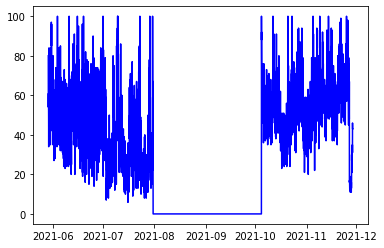

In [98]:
trend = artifact_trend_table_new.loc[artifact_trend_table_new['artifact_id'] == 154]
#trend = artifact_trend_table.loc[artifact_trend_table['artifact_id'] == 87]


plt.plot(trend['date'], trend['hype'], color="blue")
#plt.show()

In [10]:
start = [00,7,10,2021]
end = [1,9,10,2021]
artifact_id = 23
pd.set_option('display.max_rows', 133481)
# get_trends_3(['Audius'], start, end)

pytrends = TrendReq(hl='en-GB')
pytrends.get_historical_interest(['Audius'], 
                                year_start=start[3], 
                                month_start=start[2], 
                                day_start=start[1], 
                                hour_start=start[0], 
                                year_end=end[3], 
                                month_end=end[2], 
                                day_end=end[1], 
                                hour_end=start[0], 
                                cat=0, 
                                geo='', 
                                gprop='', 
                                sleep=sleepval)

,Audius,isPartial
date,,
2021-10-07 00:00:00,100,False
2021-10-07 01:00:00,72,False
2021-10-07 02:00:00,100,False
2021-10-07 03:00:00,81,False
2021-10-07 04:00:00,69,False
2021-10-07 05:00:00,46,False
2021-10-07 06:00:00,61,False
2021-10-07 07:00:00,60,False
2021-10-07 08:00:00,96,False
